In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
from pathlib import Path
import torch
import random
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib
import matplotlib.pyplot as plt
#pydicom
import pydicom
import cv2
from PIL import Image, ImageOps
from torchvision import transforms
import glob, os
from shutil import copyfile
from random import randrange
import uuid

In [4]:
from lib import common

In [5]:
pd.options.mode.chained_assignment = None

### Path

In [6]:
path = Path('/kaggle/osic_pulmonary')
assert path.exists()

### Read Data

In [7]:
train_df, test_df, submission_df = common.read_data(path)

### Read Images

In [8]:
!ls {path}/train | head

ID00007637202177411956430
ID00009637202177434476278
ID00010637202177584971671
ID00011637202177653955184
ID00012637202177665765362
ID00014637202177757139317
ID00015637202177877247924
ID00019637202178323708467
ID00020637202178344345685
ID00023637202179104603099


In [9]:
!find {path} -type f -name '*.png' -delete
!find {path} -type f -name '*-*-*' -delete

In [10]:
def create_new_images(folder_path, n):
    for i in range(n):
        images_path = os.listdir(folder_path)
        im_index = randrange(len(images_path))
        uuid_str = str(uuid.uuid4())
        copyfile(f'{folder_path}/{images_path[im_index]}', f'{folder_path}/{uuid_str}_{images_path[im_index]}')

In [11]:
NUM_PROCESSED = 50
IMAGE_SIZE = 128

def dicom_to_image3(filename):
    im = pydicom.dcmread(filename)
    img = im.pixel_array
    img[img == -2000] = 0
    return img

def convert_images(folder_path, size = (IMAGE_SIZE, IMAGE_SIZE)):
    images_path = os.listdir(folder_path)
    missing_image_count = NUM_PROCESSED - len(images_path)
    if missing_image_count > 0:
        print(f'Missing {missing_image_count} images.')
        create_new_images(folder_path, missing_image_count)
    images_path = os.listdir(folder_path)
    for n, image in enumerate(images_path):
        if (image.find('.dcm') > 0 and n < NUM_PROCESSED):
            pixel_array_numpy = dicom_to_image3(os.path.join(folder_path, image))
            image = image.replace('.dcm', f'_{size[0]}.png')
            full_image = os.path.join(folder_path, image) 
            matplotlib.image.imsave(full_image, pixel_array_numpy)
            im = Image.open(full_image).convert('LA')
            im = ImageOps.fit(im, size, Image.ANTIALIAS)
            im.save(full_image, "PNG")
    len_images_path = len(images_path)
    print(f"finished {folder_path} ({len_images_path})")
    return len_images_path

In [12]:
convert_images(f"{path}/train/ID00248637202266698862378")

Missing 34 images.
finished /kaggle/osic_pulmonary/train/ID00248637202266698862378 (50)


50

In [13]:
!ls /kaggle/osic_pulmonary/train/ID00248637202266698862378/*.png | wc -l

50


In [14]:
from multiprocessing import Process

def convert_images_in_single_set(split, file_type):
    min_img_length = 10000000
    for p in tqdm(split, total=len(split)):
        img_length = convert_images(f'{path}/{file_type}/{p}')
        min_img_length = min(min_img_length, img_length)
    return min_img_length

def convert_images_in_dataset(file_type='train'):
    unique_patients = train_df['Patient'].unique() if file_type == 'train' else test_df['Patient'].unique()
    unique_patients_splits = np.array_split(unique_patients, 8)
    procs = []
    min_images_length = 10000000
    img_length = 0
    for split in unique_patients_splits:
        img_length = convert_images_in_single_set(split, file_type)
        min_images_length = min(min_images_length, img_length)
#         proc = Process(target=convert_images_in_single_set, args=(split, file_type))
#         procs.append(proc)
#         proc.start()
        
    # complete the processes
#     for proc in procs:
#         proc.join()

    print(f'min_images_length: {min_images_length}')


In [15]:
%%time
convert_images_in_dataset()

Missing 20 images.
finished /kaggle/osic_pulmonary/train/ID00007637202177411956430 (50)
finished /kaggle/osic_pulmonary/train/ID00009637202177434476278 (394)
finished /kaggle/osic_pulmonary/train/ID00010637202177584971671 (106)
Missing 19 images.
finished /kaggle/osic_pulmonary/train/ID00011637202177653955184 (50)
Missing 1 images.
finished /kaggle/osic_pulmonary/train/ID00012637202177665765362 (50)
Missing 19 images.
finished /kaggle/osic_pulmonary/train/ID00014637202177757139317 (50)
finished /kaggle/osic_pulmonary/train/ID00015637202177877247924 (295)
Missing 21 images.
finished /kaggle/osic_pulmonary/train/ID00019637202178323708467 (50)
finished /kaggle/osic_pulmonary/train/ID00020637202178344345685 (493)
Missing 23 images.
finished /kaggle/osic_pulmonary/train/ID00023637202179104603099 (50)
Missing 26 images.
finished /kaggle/osic_pulmonary/train/ID00025637202179541264076 (50)
finished /kaggle/osic_pulmonary/train/ID00026637202179561894768 (239)
finished /kaggle/osic_pulmonary/tra

finished /kaggle/osic_pulmonary/train/ID00060637202187965290703 (275)
finished /kaggle/osic_pulmonary/train/ID00061637202188184085559 (253)
Missing 20 images.
finished /kaggle/osic_pulmonary/train/ID00062637202188654068490 (50)
finished /kaggle/osic_pulmonary/train/ID00067637202189903532242 (319)
finished /kaggle/osic_pulmonary/train/ID00068637202190879923934 (118)
Missing 26 images.
finished /kaggle/osic_pulmonary/train/ID00072637202198161894406 (50)
finished /kaggle/osic_pulmonary/train/ID00073637202198167792918 (355)
finished /kaggle/osic_pulmonary/train/ID00075637202198610425520 (320)
finished /kaggle/osic_pulmonary/train/ID00076637202199015035026 (64)
finished /kaggle/osic_pulmonary/train/ID00077637202199102000916 (94)
finished /kaggle/osic_pulmonary/train/ID00078637202199415319443 (1018)
finished /kaggle/osic_pulmonary/train/ID00082637202201836229724 (266)
Missing 20 images.
finished /kaggle/osic_pulmonary/train/ID00086637202203494931510 (50)
Missing 14 images.
finished /kaggle/o

finished /kaggle/osic_pulmonary/train/ID00109637202210454292264 (300)
finished /kaggle/osic_pulmonary/train/ID00110637202210673668310 (211)
finished /kaggle/osic_pulmonary/train/ID00111637202210956877205 (302)
Missing 26 images.
finished /kaggle/osic_pulmonary/train/ID00115637202211874187958 (50)
Missing 20 images.
finished /kaggle/osic_pulmonary/train/ID00117637202212360228007 (50)
finished /kaggle/osic_pulmonary/train/ID00119637202215426335765 (71)
finished /kaggle/osic_pulmonary/train/ID00122637202216437668965 (71)
finished /kaggle/osic_pulmonary/train/ID00123637202217151272140 (258)
finished /kaggle/osic_pulmonary/train/ID00124637202217596410344 (398)
Missing 28 images.
finished /kaggle/osic_pulmonary/train/ID00125637202218590429387 (50)
Missing 33 images.
finished /kaggle/osic_pulmonary/train/ID00126637202218610655908 (50)
finished /kaggle/osic_pulmonary/train/ID00127637202219096738943 (50)
Missing 2 images.
finished /kaggle/osic_pulmonary/train/ID00128637202219474716089 (50)
Miss

finished /kaggle/osic_pulmonary/train/ID00139637202231703564336 (64)
finished /kaggle/osic_pulmonary/train/ID00140637202231728595149 (271)
finished /kaggle/osic_pulmonary/train/ID00149637202232704462834 (245)
Missing 22 images.
finished /kaggle/osic_pulmonary/train/ID00161637202235731948764 (50)
Missing 38 images.
finished /kaggle/osic_pulmonary/train/ID00165637202237320314458 (50)
finished /kaggle/osic_pulmonary/train/ID00167637202237397919352 (221)
finished /kaggle/osic_pulmonary/train/ID00168637202237852027833 (253)
finished /kaggle/osic_pulmonary/train/ID00169637202238024117706 (115)
finished /kaggle/osic_pulmonary/train/ID00170637202238079193844 (178)
Missing 19 images.
finished /kaggle/osic_pulmonary/train/ID00172637202238316925179 (50)
finished /kaggle/osic_pulmonary/train/ID00173637202238329754031 (602)
finished /kaggle/osic_pulmonary/train/ID00180637202240177410333 (577)
finished /kaggle/osic_pulmonary/train/ID00183637202241995351650 (56)
finished /kaggle/osic_pulmonary/train/

finished /kaggle/osic_pulmonary/train/ID00210637202257228694086 (303)
finished /kaggle/osic_pulmonary/train/ID00213637202257692916109 (268)
Missing 32 images.
finished /kaggle/osic_pulmonary/train/ID00214637202257820847190 (50)
Missing 29 images.
finished /kaggle/osic_pulmonary/train/ID00216637202257988213445 (50)
finished /kaggle/osic_pulmonary/train/ID00218637202258156844710 (64)
finished /kaggle/osic_pulmonary/train/ID00219637202258203123958 (375)
finished /kaggle/osic_pulmonary/train/ID00221637202258717315571 (465)
finished /kaggle/osic_pulmonary/train/ID00222637202259066229764 (58)
finished /kaggle/osic_pulmonary/train/ID00224637202259281193413 (54)
finished /kaggle/osic_pulmonary/train/ID00225637202259339837603 (207)
finished /kaggle/osic_pulmonary/train/ID00228637202259965313869 (347)
Missing 33 images.
finished /kaggle/osic_pulmonary/train/ID00229637202260254240583 (50)
finished /kaggle/osic_pulmonary/train/ID00232637202260377586117 (67)
finished /kaggle/osic_pulmonary/train/ID

Missing 20 images.
finished /kaggle/osic_pulmonary/train/ID00255637202267923028520 (50)
finished /kaggle/osic_pulmonary/train/ID00264637202270643353440 (61)
finished /kaggle/osic_pulmonary/train/ID00267637202270790561585 (63)
finished /kaggle/osic_pulmonary/train/ID00273637202271319294586 (74)
finished /kaggle/osic_pulmonary/train/ID00275637202271440119890 (284)
Missing 25 images.
finished /kaggle/osic_pulmonary/train/ID00276637202271694539978 (50)
Missing 20 images.
finished /kaggle/osic_pulmonary/train/ID00279637202272164826258 (50)
finished /kaggle/osic_pulmonary/train/ID00283637202278714365037 (306)
Missing 19 images.
finished /kaggle/osic_pulmonary/train/ID00285637202278913507108 (50)
Missing 24 images.
finished /kaggle/osic_pulmonary/train/ID00288637202279148973731 (50)
finished /kaggle/osic_pulmonary/train/ID00290637202279304677843 (240)
finished /kaggle/osic_pulmonary/train/ID00291637202279398396106 (485)
Missing 15 images.
finished /kaggle/osic_pulmonary/train/ID00294637202279

finished /kaggle/osic_pulmonary/train/ID00322637202284842245491 (106)
finished /kaggle/osic_pulmonary/train/ID00323637202285211956970 (258)
finished /kaggle/osic_pulmonary/train/ID00329637202285906759848 (260)
finished /kaggle/osic_pulmonary/train/ID00331637202286306023714 (74)
Missing 20 images.
finished /kaggle/osic_pulmonary/train/ID00335637202286784464927 (50)
Missing 17 images.
finished /kaggle/osic_pulmonary/train/ID00336637202286801879145 (50)
finished /kaggle/osic_pulmonary/train/ID00337637202286839091062 (64)
finished /kaggle/osic_pulmonary/train/ID00339637202287377736231 (56)
Missing 20 images.
finished /kaggle/osic_pulmonary/train/ID00340637202287399835821 (50)
finished /kaggle/osic_pulmonary/train/ID00341637202287410878488 (60)
Missing 23 images.
finished /kaggle/osic_pulmonary/train/ID00342637202287526592911 (50)
Missing 11 images.
finished /kaggle/osic_pulmonary/train/ID00343637202287577133798 (50)
finished /kaggle/osic_pulmonary/train/ID00344637202287684217717 (201)
Miss

finished /kaggle/osic_pulmonary/train/ID00371637202296828615743 (364)
finished /kaggle/osic_pulmonary/train/ID00376637202297677828573 (396)
finished /kaggle/osic_pulmonary/train/ID00378637202298597306391 (346)
finished /kaggle/osic_pulmonary/train/ID00381637202299644114027 (423)
Missing 18 images.
finished /kaggle/osic_pulmonary/train/ID00383637202300493233675 (50)
finished /kaggle/osic_pulmonary/train/ID00388637202301028491611 (429)
finished /kaggle/osic_pulmonary/train/ID00392637202302319160044 (56)
finished /kaggle/osic_pulmonary/train/ID00393637202302431697467 (478)
Missing 1 images.
finished /kaggle/osic_pulmonary/train/ID00398637202303897337979 (50)
finished /kaggle/osic_pulmonary/train/ID00400637202305055099402 (265)
Missing 26 images.
finished /kaggle/osic_pulmonary/train/ID00401637202305320178010 (50)
Missing 20 images.
finished /kaggle/osic_pulmonary/train/ID00405637202308359492977 (50)
finished /kaggle/osic_pulmonary/train/ID00407637202308788732304 (54)
Missing 14 images.
fi

In [16]:
%%time
convert_images_in_dataset(file_type='test')

Missing 22 images.
finished /kaggle/osic_pulmonary/test/ID00419637202311204720264 (50)



finished /kaggle/osic_pulmonary/test/ID00421637202311550012437 (62)



finished /kaggle/osic_pulmonary/test/ID00422637202311677017371 (473)



finished /kaggle/osic_pulmonary/test/ID00423637202312137826377 (290)



finished /kaggle/osic_pulmonary/test/ID00426637202313170790466 (408)




min_images_length: 50
CPU times: user 30.6 s, sys: 116 ms, total: 30.7 s
Wall time: 30.7 s


In [17]:
def read_dicom(patient):
    image_ds = pydicom.dcmread(path/f"train/{patient}/1.dcm")
    return image_ds.pixel_array.astype('int32')

def transform_image(patient):
    image = transforms.functional.to_tensor(read_dicom(patient))
    return image

torch.Size([1, 768, 768])


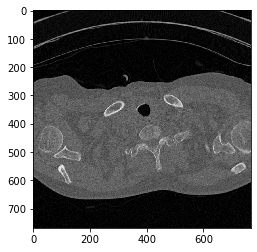

In [18]:
sample_image = transform_image('ID00421637202311550012437')
print(sample_image.shape)
plt.imshow(sample_image.squeeze(0), cmap='gray')

In [19]:
def read_png(patient, ds_type='train'):
    os.chdir(path/f"{ds_type}/{patient}")
    img_files = glob.glob("*.png")
    full_path = path/f"{ds_type}/{patient}/{img_files[0]}"
    pil_img = Image.open(full_path)
    return transforms.functional.to_tensor(pil_img)

read_png('ID00419637202311204720264').shape

torch.Size([2, 128, 128])

In [20]:
torch.cat([read_png(patient) for patient in ['ID00419637202311204720264', 'ID00421637202311550012437']], 1)

tensor([[[0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
         [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
         [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5137],
         ...,
         [0.1294, 0.1333, 0.1333,  ..., 0.1333, 0.1333, 0.1294],
         [0.1294, 0.1333, 0.1333,  ..., 0.1294, 0.1333, 0.1333],
         [0.1333, 0.1333, 0.1333,  ..., 0.1294, 0.1333, 0.1294]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])

In [21]:
!zip {path}/osic_images.zip -r {path} -i '*.png'

  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/2_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/358_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/77_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/11_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/216_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/16_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/155_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/161_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/146_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/317_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train/ID00219637202258203123958/239_128.png (stored 0%)
  adding: kaggle/osic_pulmonary/train

In [23]:
!ls -la {path}
!du -h {path}/osic_images.zip

total 85152
drwxr-xr-x   5 root root     4096 Aug 17 10:36 .
drwxr-xr-x   8 root root     4096 Jul 29 09:51 ..
drwxr-xr-x   2 root root     4096 Aug 10 20:23 model
-rw-r--r--   1 root root 87021004 Aug 17 10:36 osic_images.zip
-rw-r--r--   1 root root    27903 Jul 10 21:54 sample_submission.csv
drwxr-xr-x   7 root root     4096 Jul 29 09:51 test
-rw-r--r--   1 root root      392 Jul 10 21:54 test.csv
drwxr-xr-x 178 root root    12288 Jul 29 09:54 train
-rw-r--r--   1 root root   108892 Jul 10 21:59 train.csv
83M	/kaggle/osic_pulmonary/osic_images.zip
